In [1]:
library(tidyverse)
library(Seurat)
library(patchwork)
library(corrplot)
library(ComplexHeatmap)
library(UCell)
library(biomaRt)
library(here)

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.4.2     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.1     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: SeuratObject

Loading required package: sp

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 


Attaching package: 'SeuratObject'


The following objects are masked from 'package:base':

    intersect, saveRDS


Loading Seurat v5 beta versi

In [2]:
# Function to reformat gene names, human → mouse

mouse_human_genes <- read.csv("http://www.informatics.jax.org/downloads/reports/HOM_MouseHumanSequence.rpt", sep = "\t")
head(mouse_human_genes)
convert_human_to_mouse <- function(gene_list) {
    output <- c()
    for (gene in gene_list) {
        class_key <- (mouse_human_genes %>% filter(Symbol == gene & Common.Organism.Name == "human"))[["DB.Class.Key"]]
        if (!identical(class_key, integer(0))) {
            mouse_genes <- (mouse_human_genes %>%
                filter(DB.Class.Key == class_key & Common.Organism.Name == "mouse, laboratory"))[, "Symbol"]
            for (mouse_gene in mouse_genes) {
                output <- append(output, mouse_gene)
            }
        }
    }
    return(output)
}

,DB.Class.Key,Common.Organism.Name,NCBI.Taxon.ID,Symbol,EntrezGene.ID,Mouse.MGI.ID,HGNC.ID,OMIM.Gene.ID,Genetic.Location,Genome.Coordinates..mouse..GRCm39.human..GRCh38.p7.,Nucleotide.RefSeq.IDs,Protein.RefSeq.IDs,SWISS_PROT.IDs
,<int>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,44282755,"mouse, laboratory",10090,Wdr53,68980,MGI:1916230,,,Chr16 22.47 cM,Chr16:32066045-32075901(+),"NM_001399294,NM_001185162,NM_026898","NP_001386223,NP_001172091,NP_081174",Q9DB94
2,44282755,human,9606,WDR53,348793,,HGNC:28786,OMIM:615110,Chr3 q29,Chr3:196554188-196568542(-),"NM_001345906,NM_001345907,NM_001345908,NM_001345909,NM_001345910,NM_001345911,NM_001345912,NM_001345913,NM_001345914,NM_001345915,NM_001345917,NM_001345918,NM_182627","NP_001332835,NP_001332836,NP_001332837,NP_001332838,NP_001332839,NP_001332840,NP_001332841,NP_001332842,NP_001332843,NP_001332844,NP_001332846,NP_001332847,NP_872433,XP_047304035,XP_047304036,XP_054202413,XP_054202414",Q7Z5U6
3,44282756,"mouse, laboratory",10090,Tdg,21665,MGI:108247,,,Chr10 39.72 cM,Chr10:82465662-82486633(+),"NM_001358517,NM_172552,NM_011561,XM_030245048","XP_030100908,NP_035691,NP_766140,NP_001345446",P56581
4,44282756,human,9606,TDG,6996,,HGNC:11700,OMIM:601423,Chr12 q23.3,Chr12:103965815-103988878(+),"NM_003211,NM_001363612,NM_001008411,NM_003211,NM_001363612,NM_001008411","NP_001350541,NP_003202,XP_047285442,XP_047285443,XP_047285444,XP_047285445,XP_054229082,XP_054229083,XP_054229084,XP_054229085,NP_001350541,NP_003202,XP_047285442,XP_047285443,XP_047285444,XP_047285445,XP_054229082,XP_054229083,XP_054229084,XP_054229085","Q13569,Q13569"
5,44282757,"mouse, laboratory",10090,Trarg1,237858,MGI:3029307,,,Chr11 45.98 cM,Chr11:76570699-76589490(+),NM_177709,NP_808377,Q8C838
6,44282757,human,9606,TRARG1,286753,,HGNC:29592,OMIM:612211,Chr17 p13.3,Chr17:1279663-1300987(+),NM_172367,NP_758955,Q8IXB3


## Gene signatures from this study

In [3]:
cd34_signatures <- read_csv(here("Figure1_S1", "data", "Cd34hi-lo-markers.csv"))
head(cd34_signatures)

g_Cd34hi <- cd34_signatures %>%
    filter(cluster == "Fib_CD34+") %>%
    filter(p_val_adj < 0.01 & avg_log2FC > 1) # %>%
# slice_max(avg_log2FC, n = 24)
g_Cd34hi <- g_Cd34hi$gene
g_Cd34hi

g_Cd34lo <- cd34_signatures %>%
    filter(cluster == "Fib_CD34-") %>%
    filter(p_val_adj < 0.01 & avg_log2FC > 1) # %>%
# slice_max(avg_log2FC, n = 24)
g_Cd34lo <- g_Cd34lo$gene
g_Cd34lo

Rows: 1618 Columns: 7
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (2): cluster, gene
dbl (5): p_val, avg_log2FC, pct.1, pct.2, p_val_adj

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1.293753e-240,2.690754,0.991,0.371,2.429668e-236,Fib_CD34-,Prkg2
2.911405e-230,2.317446,0.991,0.492,5.467618e-226,Fib_CD34-,Lgals3
2.422801e-198,2.236109,0.997,0.783,4.550021e-194,Fib_CD34-,Ly6c1
5.015972e-205,2.233782,0.891,0.113,9.419995e-201,Fib_CD34-,Ifitm1
2.730079e-66,2.100291,0.691,0.274,5.127088e-62,Fib_CD34-,Spp1
4.658154e-198,2.049445,0.964,0.395,8.748014e-194,Fib_CD34-,H2bc4


[1] "Dcn"           "Gas6"          "Rbp1"          "Igfbp5"       
 [5] "Dlk1"          "Cd34"          "Rpl22l1"       "Tmem176b"     
 [9] "Sfrp1"         "Pdgfra"        "Clu"           "Ptn"          
[13] "Rpl18"         "Rhox5"         "Lbp"           "Ptgis"        
[17] "Rps11"         "Lcn2"          "Cyba"          "Fabp5"        
[21] "Cygb"          "Sfrp2"         "Txnip"         "Lum"          
[25] "Irx1"          "Cthrc1"        "Wnt4"          "Ces1d"        
[29] "Rps3a1"        "2410006H16Rik" "Vcam1"         "Rps24"        
[33] "Tmem176a"      "Tpt1"          "Rpsa"          "Fibin"        
[37] "Rpl30"         "Rps28"         "C3"            "Rpl32"        
[41] "Abi3bp"        "Pdlim4"        "Fau"           "Rps25"        
[45] "Smoc2"         "C1qtnf4"       "Mfap2"         "Ier3"         
[49] "Rps26"         "Gas5"          "Meg3"          "Rps12"        
[53] "Enpp2"         "Fam180a"       "Rpl21"

[1] "Prkg2"    "Lgals3"   "Ly6c1"    "Ifitm1"   "Spp1"     "H2bc4"   
 [7] "Vcan"     "Hgf"      "S100a4"   "Basp1"    "Ereg"     "Tmem167" 
[13] "S100a10"  "Ifi27l2a" "Adamts1"  "Crlf1"    "Ctsl"     "Gm5886"  
[19] "Ccl2"     "Actb"     "Actg1"    "Mmp3"     "Tpm4"     "Ssr4"    
[25] "Sat1"     "Tmsb4x"   "Neat1"    "Cavin3"   "Hand2"    "Cd55"    
[31] "Prdx4"    "Ndn"      "Lmo4"     "Pde10a"   "Fn1"      "Selenow" 
[37] "Npc2"     "Tmsb10"   "H2aj"     "Calm1"    "Pdlim2"   "Isg15"   
[43] "Cd24a"    "Ctsd"     "Gucy1b1"  "Grem1"    "Sh3glb1"  "Mfge8"   
[49] "Fstl1"    "Siva1"    "Gdpd2"    "Pdia6"    "Defb41"   "Ugp2"    
[55] "Timp1"    "S100a11"  "Errfi1"   "Mrps6"    "Ly6a"     "Rhoc"    
[61] "Calr"

## Collate published gene lists

In [5]:
# zotero://select/items/@karpus_colonic_2019
#* Human
cd90_signatures <- read_csv(
    here("Figure1_S1", "data", "published_signatures", "List of upregulated genes in CD90+ cells - soluble markers.csv"),
    col_names = FALSE
) %>%
    as.vector() %>%
    magrittr::extract2("X1")
g_cd90_KARPUS19 <- convert_human_to_mouse(cd90_signatures)


Rows: 114 Columns: 1
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (1): X1

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
"There was 1 warning in `filter()`.
i In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse,
  laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object length is not a multiple of shorter object length"
Warning message:
"There was 1 warning in `filter()`.
i In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse,
  laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object length is not a multiple of shorter object length"


In [6]:
# zotero://select/items/@degirmenciGLI1expressingMesenchymalCells2018

g_C1_C3_DEGIRMENCI18 <- c("Wnt2", "Wnt2b", "Wnt4", "Rspo3", "Pdgfra", "Rbp1", "Sfrp1", "Cd34")
g_C2_DEGIRMENCI18 <- c("Foxl1", "Myh11", "Acta2")

In [7]:
# zotero://select/items/@muhl_singlecell_2020

g_Cd34hi_MUHL20 <- c("Wnt2", "Wnt2b", "Fzd1", "Fzd4", "Sfrp1", "Cd34", "Grem1", "Ndrg2")
g_Cd34lo_MUHL20 <- c("Tnc", "Il1rl1", "Ptgs2", "Bmp2", "Bmp5", "Bmp7", "Foxl1")

In [8]:
# zotero://select/items/@stzepourginski_cd34_2017

g_Cd34hiCSC_STZEPOURGINSKI17 <- c("Wnt2b", "Vegfc", "Areg", "Vegfd", "Cd34")
g_Cd34loMyoF_STZEPOURGINSKI17 <- c("Wnt5a", "Bmp7", "Bmp2", "Fgf7", "Vegfa", "Angpt1", "Acta2", "Angpt2")

In [9]:
# zotero://select/items/@brugger_distinct_2020

g_CBF1_BRUGGER20 <- c(
    "Adam23", "Igfbp5", "Serpine2", "Pid1", "Hsd11b1", "Itih5", "Ptges", "Sulf2", "Stmn2", "Dclk1",
    "Fam198b", "Hmgcs2", "Vcam1", "Col15a1", "Lepr", "Wnt4", "Cdk14", "Htra3", "Hpse", "Hebp1", "Mgp",
    "Aldh1a3", "Fgfr2", "Enpp3", "Tnfsf13b", "Nrp1", "Vstm4", "Clec3b", "Igfbp3", "Adamts2", "Ccl11",
    "Igfbp4", "Ramp2", "Edf3", "Serpina3n", "C1qtnf3", "Matn2", "C4b", "Xdh", "Cdc42ep2", "Add3"
)
g_CBF2_BRUGGER20 <- c(
    "Cd55", "Cth", "Cd34", "Entpd2", "Ar", "Fbln2", "Adamtsl3", "Prss23", "Cd81",
    "Pcolce1", "Scara5", "Cilp", "Rbp1", "Ackr4", "Ebf1", "Col14a1", "Pi16", "C3", "Cd248", "Il33"
)
g_CTF_BRUGGER20 <- c(
    "Ccdc3", "Ptgs1", "Cybrd1", "Fibin", "Procr", "Bmp7", "Tspan6", "Srpx2", "Col4a6", "Col4a5", "F3",
    "Col27a1", "Tnc", "Bmp3", "Fry", "Eva1a", "Rerg", "Sox6", "Ptpre", "Ifitm1", "Gja1", "Bean1", "Atg",
    "Wnt5a", "Galnt15", "Fgf9", "Ednrb", "Sema3f", "Tmem158", "Emid1", "Glp2r", "Sept4", "Cxcl14",
    "Tspan13", "Basp1", "Cd200", "Aldh1a1"
)

In [10]:
# zotero://select/items/@jasso_colon_2022

g_Fib1_JASSO22 <- c("Sfrp1", "Grem1", "Wnt5b", "Wnt4", "Wnt2", "Wnt2b")
g_Fib2_JASSO22 <- c("Wnt5a", "Bmp2", "Bmp5", "Bmp7", "Procr", "Sox6", "Acta2") # "Dkk3", "Tcf4",
g_Fib3_JASSO22 <- c("Ackr4", "Cd81", "Pcolce2", "C3", "Pi16", "Has1") # "Cd55"

In [11]:
# zotero://select/items/@kinchen_structural_2018
#* Human

kinchen_structural_2018 <- read_csv(here("Figure1_S1", "data", "published_signatures", "1-s2.0-S0092867418311681-mmc3.csv"), col_names = TRUE)
head(kinchen_structural_2018)
unique(kinchen_structural_2018$cluster)

# * avg_diff is the same as avg_logFC. I need to filter >0 for cluster markers.
# https://github.com/satijalab/seurat/issues/367
# TODO: Check with Ferran

g_myofib_human_KINCHEN18 <- kinchen_structural_2018 %>%
    filter(cluster == "Myofibroblasts") %>%
    filter(avg_diff > 1)
g_myofib_human_KINCHEN18 <- convert_human_to_mouse(g_myofib_human_KINCHEN18$gene) 

g_str1_human_KINCHEN18 <- kinchen_structural_2018 %>%
    filter(cluster == "Stromal 1") %>%
    filter(avg_diff > 1)
g_str1_human_KINCHEN18 <- convert_human_to_mouse(g_str1_human_KINCHEN18$gene) 

g_str2_human_KINCHEN18 <- kinchen_structural_2018 %>%
    filter(cluster == "Stromal 2") %>%
    filter(avg_diff > 1)
g_str2_human_KINCHEN18 <- convert_human_to_mouse(g_str2_human_KINCHEN18$gene)

g_str3_human_KINCHEN18 <- kinchen_structural_2018 %>%
    filter(cluster == "Stromal 3") %>%
    filter(avg_diff > 1)
g_str3_human_KINCHEN18 <- convert_human_to_mouse(g_str3_human_KINCHEN18$gene) 

g_str4_human_KINCHEN18 <- kinchen_structural_2018 %>%
    filter(cluster == "Stromal 4") %>%
    filter(avg_diff > 1)
g_str4_human_KINCHEN18 <- convert_human_to_mouse(g_str4_human_KINCHEN18$gene)

g_myofib_human_KINCHEN18
g_str1_human_KINCHEN18
g_str2_human_KINCHEN18
g_str3_human_KINCHEN18
g_str4_human_KINCHEN18

Rows: 7915 Columns: 8


-- Column specification --------------------------------------------------------
Delimiter: ","
chr (2): cluster, gene
dbl (6): AUC, avg_diff, power, avg_logFC, pct.1, pct.2

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


AUC,avg_diff,power,avg_logFC,pct.1,pct.2,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.976,2.089229,0.952,2.089229,0.992,0.581,Endothelial,IFI27
0.974,2.396269,0.948,2.396269,0.963,0.181,Endothelial,RAMP2
0.974,1.403504,0.948,1.403504,1.000,0.830,Endothelial,HLA-E
0.971,2.123961,0.942,2.123961,0.946,0.059,Endothelial,PECAM1
0.968,2.471740,0.936,2.471740,0.988,0.378,Endothelial,CD74
0.967,2.314877,0.934,2.314877,0.950,0.048,Endothelial,HLA-DRB1


[1] "Endothelial"    "Glial"          "Myofibroblasts" "Pericytes"     
[5] "Plasma Cells"   "Stromal 1"      "Stromal 2"      "Stromal 3"     
[9] "Stromal 4"

Warning message:
"There was 1 warning in `filter()`.
i In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse,
  laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object length is not a multiple of shorter object length"
Warning message:
"There was 1 warning in `filter()`.
i In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse,
  laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object length is not a multiple of shorter object length"
Warning message:
"There was 1 warning in `filter()`.
i In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse,
  laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object length is not a multiple of shorter object length"
Warning message:
"There was 1 warning in `filter()`.
i In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse,
  laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object len

[1] "Tagln"   "Actg2"   "Acta2"   "Tpm1"    "Myl6"    "Myl9"    "Tpm2"   
 [8] "Mylk"    "Myh11"   "Ndufa4"  "Hhip"    "Pdlim3"  "Sostdc1" "Dstn"   
[15] "Fhl1"    "Lpp"     "Hsd17b6" "Npnt"    "Mfap5"   "Csrp1"   "Nexn"   
[22] "Pdlim7"  "Ckb"     "Flna"    "Cnn1"    "Tgm2"    "Smtn"

[1] "Cfd"      "Adamdec1" "Ctsc"     "Apoe"     "Ccl2"     "Dcn"     
 [7] "Lum"      "Ccl8"     "Abca8b"   "Tcf21"    "Hapln1"   "Stmn2"   
[13] "Plpp3"    "Scara5"   "Ccl11"    "Vcam1"    "Ccl2"     "Fabp4"

[1] "F3"      "Postn"   "Plat"    "Frzb"    "Hsd17b2" "Pdgfra"  "Ednrb"  
 [8] "Nsg1"    "Bmp4"    "Enho"    "Aplp2"   "Vstm2a"  "Sox6"    "Mmp2"   
[15] "Igfbp3"  "Fendrr"  "Rgs10"   "Bmp5"    "Cxcr4"   "Id1"     "Nrg1"   
[22] "Tshz2"   "Scpep1"  "Bmp2"    "Palld"   "Mrps6"   "Map1b"   "Fgf9"   
[29] "Tgfbi"   "Agt"     "Mmp11"   "Trpa1"   "Tmem119" "Dmkn"    "Ch25h"  
[36] "Mmp1b"   "Apod"    "Gdf15"

[1] "Ccdc80"   "Mgp"      "Ogn"      "Fbln1"    "Dcn"      "Cfhr4"   
 [7] "Adh1"     "Cxcl12"   "Efemp1"   "Plac9"    "Gsn"      "Srpx"    
[13] "Rspo3"    "C7"       "Cp"       "Itm2a"    "Dpt"      "C3"      
[19] "Tnfsf13b" "Grem1"    "Ptgds"

[1] "C3"       "Ptgds"    "Cd74"     "Tnfsf13b" "Ctss"     "Cd24a"    "Vcam1"   
[8] "Igfbp5"

In [12]:
# zotero://select/items/@kinchen_structural_2018
#* Mouse

kinchen_structural_2018 <- read_csv(here("Figure1_S1", "data", "published_signatures", "1-s2.0-S0092867418311681-mmc6.csv"), col_names = TRUE)
head(kinchen_structural_2018)
unique(kinchen_structural_2018$cluster)


# * avg_diff is the same as avg_logFC. I need to filter >0 for cluster markers.
# https://github.com/satijalab/seurat/issues/367

g_myofib_mouse_KINCHEN18 <- kinchen_structural_2018 %>%
    filter(cluster == "Myofibroblast") %>%
    filter(avg_diff > 1)
g_myofib_mouse_KINCHEN18 <- g_myofib_mouse_KINCHEN18$gene 

g_str1.1_mouse_KINCHEN18 <- kinchen_structural_2018 %>%
    filter(cluster == "Str1.1") %>%
    filter(avg_diff > 1)
g_str1.1_mouse_KINCHEN18 <- g_str1.1_mouse_KINCHEN18$gene 

g_str1.2_mouse_KINCHEN18 <- kinchen_structural_2018 %>%
    filter(cluster == "Str1.2") %>%
    filter(avg_diff > 1)
g_str1.2_mouse_KINCHEN18 <- g_str1.2_mouse_KINCHEN18$gene

g_str1.3_mouse_KINCHEN18 <- kinchen_structural_2018 %>%
    filter(cluster == "Str1.3") %>%
    filter(avg_diff > 1)
g_str1.3_mouse_KINCHEN18 <- g_str1.3_mouse_KINCHEN18$gene

g_str2_mouse_KINCHEN18 <- kinchen_structural_2018 %>%
    filter(cluster == "Str2") %>%
    filter(avg_diff > 1)
g_str2_mouse_KINCHEN18 <- g_str2_mouse_KINCHEN18$gene

g_str3_mouse_KINCHEN18 <- kinchen_structural_2018 %>%
    filter(cluster == "Str3") %>%
    filter(avg_diff > 1)
g_str3_mouse_KINCHEN18 <- g_str3_mouse_KINCHEN18$gene

g_myofib_mouse_KINCHEN18
g_str1.1_mouse_KINCHEN18
g_str1.2_mouse_KINCHEN18
g_str1.3_mouse_KINCHEN18
g_str2_mouse_KINCHEN18
g_str3_mouse_KINCHEN18

Rows: 1320 Columns: 8
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (3): cluster, gene, get(grp_var)
dbl (5): myAUC, avg_diff, power, pct.1, pct.2

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


myAUC,avg_diff,power,pct.1,pct.2,cluster,gene,get(grp_var)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
0.993,2.59,0.986,1.000,0.613,Myofibroblast,Tpm2,Myofibroblast
0.992,3.20,0.984,1.000,0.268,Myofibroblast,Acta2,Myofibroblast
0.992,2.84,0.984,1.000,0.324,Myofibroblast,Myl9,Myofibroblast
0.991,2.68,0.982,0.996,0.051,Myofibroblast,Actg2,Myofibroblast
0.990,1.78,0.980,1.000,0.887,Myofibroblast,Dstn,Myofibroblast
0.989,2.39,0.978,0.996,0.225,Myofibroblast,Mylk,Myofibroblast


[1] "Myofibroblast" "Str1.1"        "Str1.2"        "Str1.3"       
[5] "Str2"          "Str3"

[1] "Tpm2"     "Acta2"    "Myl9"     "Actg2"    "Dstn"     "Mylk"    
 [7] "Tagln"    "Tpm1"     "Myh11"    "Lmod1"    "Flna"     "Ckb"     
[13] "Cnn1"     "Csrp1"    "Hhip"     "Rgs10"    "Pbxip1"   "Pdlim3"  
[19] "Filip1l"  "Tgfb1i1"  "Prkcdbp"  "Ccdc107"  "Ppp1r14a" "Mustn1"  
[25] "Lpp"      "Tinagl1"  "Actn1"    "Nexn"     "Rbpms"    "Cdc42ep3"
[31] "Palld"    "Map1b"    "Wdr1"     "Rbp4"     "Mgll"     "Tspan2"  
[37] "Fam101b"  "Bok"      "F2r"      "P2ry14"   "Cpxm2"    "Fbxl22"  
[43] "Gas1"     "Casq2"

[1] "Sfrp1"     "Igfbp3"    "Cxcl12"    "Mfap4"     "Fbln1"     "Adamdec1" 
[7] "Tnc"       "Serpina3n" "Ces1d"

[1] "Tnfsf13b" "Edil3"    "Osr1"     "Ctgf"     "C4b"      "Eln"      "Apoe"    
[8] "Stmn2"    "Sfrp2"

[1] "Ctsc"  "Hcar2"

[1] "Bmp5"     "Nbl1"     "Procr"    "Tmem158"  "Aldh1a1"  "Tcf4"    
 [7] "Emid1"    "Tmem119"  "F3"       "Sept4"    "Bmp7"     "Gja1"    
[13] "Bmp2"     "Rerg"     "Pdgfra"   "Cav1"     "Srpx2"    "AW112010"
[19] "Gnai1"    "Cxcl14"   "Wnt5a"    "Gm13889"  "Cd44"     "Ctsc"    
[25] "Tgfbi"    "Fhl2"     "Ogn"      "Rbp4"     "Nrg1"     "Thbd"    
[31] "Rgs2"

[1] "Dpt"      "C3"       "Cd81"     "Ebf1"     "Pcolce2"  "Igfbp6"  
 [7] "Gfpt2"    "Dcn"      "Col14a1"  "Has1"     "Prss23"   "Tnfaip6" 
[13] "Rbp1"     "Serpinf1" "Mt2"      "Mt1"      "Ugdh"     "Mfap5"   
[19] "Dpep1"    "Cilp"     "Penk"     "Ccl7"     "Cfh"      "Ackr4"   
[25] "Metrnl"   "Uap1"     "Pi16"     "Ifi205"   "Gm12840"  "Inmt"    
[31] "Ccl2"     "Thbs1"

In [13]:
# zotero://select/items/@smillie_intra_2019
#* Human

smillie_intra_2019 <- read_csv(here("Figure1_S1", "data", "published_signatures", "mmc2.csv"), col_names = TRUE)
head(smillie_intra_2019)
unique(smillie_intra_2019$ident)

# I'll only look at myofibroblasts for now...

g_myofib_human_SMILLIE19 <- smillie_intra_2019 %>%
    filter(ident == "Myofibroblasts") %>%
    filter(log2fc > 1)
g_myofib_human_SMILLIE19 <- convert_human_to_mouse(g_myofib_human_SMILLIE19$gene)
g_rspo3_human_SMILLIE19 <- smillie_intra_2019 %>%
    filter(ident == "RSPO3+") %>%
    filter(log2fc > 1)
g_rspo3_human_SMILLIE19 <- convert_human_to_mouse(g_rspo3_human_SMILLIE19$gene)


Rows: 2631 Columns: 18
-- Column specification --------------------------------------------------------
Delimiter: ","
chr  (3): ident, gene, coefC
dbl (13): coefD, pvalD, padjD, pvalC, padjC, mastfc, alpha, ref_alpha, mu, r...
lgl  (2): spec_h, spec_d

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


ident,gene,coefD,pvalD,padjD,coefC,pvalC,padjC,mastfc,alpha,ref_alpha,mu,ref_mu,mean,ref_mean,log2fc,spec_h,spec_d
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>
Endothelial,PLVAP,6.416580,0.00000e+00,0.00000e+00,1.883952657,3.879760e-21,3.408010e-19,5.30588962,0.91988950,0.028818061,5.704790,5.101842,5.5843224,-0.01503657,5.599359,FALSE,FALSE
Endothelial,CLDN5,5.988083,0.00000e+00,0.00000e+00,0.524106724,1.275086e-02,3.023840e-02,4.44202757,0.80801105,0.022841965,5.192200,4.947592,4.8846472,-0.50457108,5.389218,FALSE,FALSE
Endothelial,SEMA3G,5.678198,1.93140e-47,1.29932e-45,1.575564303,4.837497e-02,9.429530e-02,0.20046060,0.10497238,0.000531208,2.433955,1.199323,-0.8179564,-9.67560446,8.857648,TRUE,TRUE
Endothelial,RBP7,5.453405,6.49070e-169,3.89190e-166,0.427996115,1.768601e-01,2.823007e-01,1.33879781,0.47375691,0.005577689,3.595739,2.772045,2.5179583,-4.71395947,7.231918,TRUE,TRUE
Endothelial,MMRN2,5.392736,2.66430e-129,8.74850e-127,-0.341296669,2.290069e-01,3.499816e-01,0.79081427,0.35773481,0.007436919,2.540736,1.976407,1.0577002,-5.09452736,6.152228,FALSE,FALSE
Endothelial,GPIHBP1,5.360766,1.55892e-19,3.49010e-18,0.451967901,1.000000e+00,1.000000e+00,0.09474303,0.05248619,0.000132802,2.367936,2.066731,-1.8839673,-10.80402415,8.920057,FALSE,TRUE


[1] "Endothelial"              "F.Crypt"                 
 [3] "F.Endothelial"            "F.Fibroblast"            
 [5] "F.Stromal"                "F.Villus"                
 [7] "Inflammatory Fibroblasts" "Microvascular"           
 [9] "Myofibroblasts"           "Pericytes"               
[11] "Post-capillary Venules"   "RSPO3+"                  
[13] "WNT2B+ Fos-hi"            "WNT2B+ Fos-lo 1"         
[15] "WNT2B+ Fos-lo 2"          "WNT5B+ 1"                
[17] "WNT5B+ 2"

Warning message:
"There was 1 warning in `filter()`.
i In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse,
  laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object length is not a multiple of shorter object length"
Warning message:
"There was 1 warning in `filter()`.
i In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse,
  laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object length is not a multiple of shorter object length"
Warning message:
"There was 1 warning in `filter()`.
i In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse,
  laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object length is not a multiple of shorter object length"
Warning message:
"There was 1 warning in `filter()`.
i In argument: `DB.Class.Key == class_key & Common.Organism.Name == "mouse,
  laboratory"`.
Caused by warning in `DB.Class.Key == class_key`:
! longer object len

In [14]:
# zotero://select/items/@goto_lymphatics_2022
goto_lymphatics_2022 <- read_csv(here("Figure1_S1", "data", "published_signatures", "mmc2_goto-et-al.csv"), col_names = TRUE)
head(goto_lymphatics_2022)

g_ackr4_GOTO22 <- goto_lymphatics_2022$"ACKR4+fibroblast"
g_ackr4_GOTO22 <- convert_human_to_mouse(g_ackr4_GOTO22[!is.na(g_ackr4_GOTO22)])
g_ackr4_GOTO22

g_telocyte_GOTO22 <- goto_lymphatics_2022$"Telocyte"
g_telocyte_GOTO22 <- convert_human_to_mouse(g_telocyte_GOTO22[!is.na(g_telocyte_GOTO22)])
g_telocyte_GOTO22

g_trophocyte_GOTO22 <- goto_lymphatics_2022$"CD81+PDGFRAlow"
g_trophocyte_GOTO22 <- convert_human_to_mouse(g_trophocyte_GOTO22[!is.na(g_trophocyte_GOTO22)])
g_trophocyte_GOTO22

Rows: 762 Columns: 12
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (12): CD81+PDGFRAlow, ACKR4+fibroblast, CD81-PDGFRAlow, Telocyte, small ...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


CD81+PDGFRAlow,ACKR4+fibroblast,CD81-PDGFRAlow,Telocyte,small intestine arteriole,small intestine capillary,small intestine vein,small intestine lymphatic,colon capillary arterial,colon capillary,colon vein,colon lymphatic
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
na,na,na,na,na,na,na,na,na,na,na,na
PRSS23,IL6,OGN,TAGLN,SCGB3A1,CAR4,MADCAM1,CCL21A,CXCL12,CAR4,LRG1,CCL21A
CD81,CD81,SFRP1,TMEM158,TMEM176A,RGCC,LRG1,MMRN1,SCGB3A1,RGCC,ACKR1,LYVE1
GREM1,CHODL,CST3,EDNRB,TMEM176B,NRP1,CLDN5,LYVE1,ID1,PLPP1,VWF,MMRN1
CILP,ADM,ADAMDEC1,KCNJ8,NCOA7,COL4A1,SLCO2A1,MAF,IER2,APLNR,MADCAM1,FGL2
PCOLCE2,GFPT2,TMEM158,ALDH1A1,LY6A,KDR,BGN,FGL2,LY6A,RAMP3,BGN,LCN2


[1] "Il6"      "Cd81"     "Chodl"    "Adm"      "Gfpt2"    "Cilp"    
 [7] "Piezo2"   "Pcolce2"  "Prss23"   "Olfml2b"  "Serpine1" "Npy1r"   
[13] "Ebf1"     "Gdf6"     "Dhrs3"    "Ar"       "Col8a1"   "Ier2"    
[19] "Pi16"     "Flrt2"    "Rcan1"    "Gpc3"     "Scara5"   "Lbp"     
[25] "Vldlr"    "Fap"      "Postn"    "Grem1"    "Ism1"     "Slit2"   
[31] "Ntn4"     "Aebp1"    "Adamtsl3" "Fam180a"  "Fign"     "Rbp1"    
[37] "Lgi2"     "Osr1"     "Cpxm1"    "Col14a1"  "Tek"      "Hk2"     
[43] "Epyc"     "Pla2g2e"  "Klf4"     "Cd248"    "Ackr4"

[1] "Tagln"   "Tmem158" "Ednrb"   "Kcnj8"   "Aldh1a7" "Myl9"    "Thbd"   
 [8] "Cald1"   "Tspan13" "Pdgfra"  "Bmp5"    "Higd1a"  "Tmem119" "Ednra"  
[15] "Bmp7"    "F2r"     "Tcf4"    "Abcc9"   "Nbl1"    "Sox6"    "Capzb"  
[22] "Procr"   "Emid1"   "Rgs10"   "Alcam"   "Gadd45a" "Bmp3"    "Sox4"   
[29] "Gja6"    "Smoc2"   "Pdlim1"  "Efemp1"  "Rerg"    "Acta2"   "Casq2"  
[36] "Tpm2"    "Fhl2"    "Pdlim3"  "Tspan6"  "Cav1"    "Bpgm"    "Mgarp"  
[43] "Gnai1"   "Col12a1" "Ogn"     "Plat"    "Wif1"

[1] "Prss23"  "Cd81"    "Grem1"   "Cilp"    "Pcolce2" "Ackr4"   "Col14a1"
 [8] "Dpt"     "Aebp1"   "Rbp1"    "Igfbp6"  "Stc2"    "Postn"   "Ebf1"   
[15] "Mfap5"   "Pi16"

## Calculate UCell scores

[1] "monoFib"

[1] 17151  1625

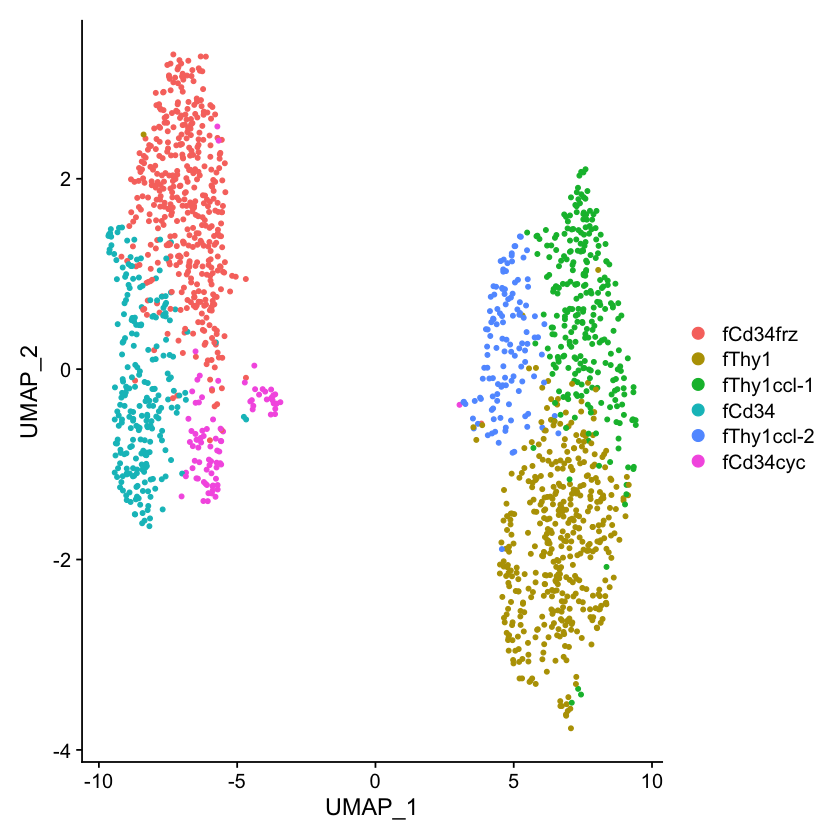

In [16]:
# Get fibroblast monoculture from the 19-plex experiment
jan21_tmecontrols <- readRDS(here("Figure1_S1", "data", "jan21_tmecontrols.rds")) # Deposited at Zenodo
d_fib <- jan21_tmecontrols[[1]]
d_fib@project.name
dim(d_fib)

d_fib <- subset(d_fib, subset = mito_content < 3 &
    nCount_RNA > 4800 &
    nCount_RNA < 50000 &
    nFeature_RNA > 2000 &
    nFeature_RNA < 7600)

DimPlot(d_fib, reduction = "umap")

In [17]:
d_fib_ucell <- UCell::AddModuleScore_UCell(
    obj = d_fib,
    features = list(
        C1_C3_DEGIRMENCI18 = g_C1_C3_DEGIRMENCI18,
        C2_DEGIRMENCI18 = g_C2_DEGIRMENCI18,
        Cd34hiMUHL20 = g_Cd34hi_MUHL20,
        Cd34loMUHL20 = g_Cd34lo_MUHL20,
        Cd34hiCSC_STZEPOURGINSKI17 = g_Cd34hiCSC_STZEPOURGINSKI17,
        Cd34loMyoF_STZEPOURGINSKI17 = g_Cd34loMyoF_STZEPOURGINSKI17,
        CBF1_BRUGGER20 = g_CBF1_BRUGGER20,
        CBF2_BRUGGER20 = g_CBF2_BRUGGER20,
        CTF_BRUGGER20 = g_CTF_BRUGGER20,
        Fib1_JASSO22 = g_Fib1_JASSO22,
        Fib2_JASSO22 = g_Fib2_JASSO22,
        Fib3_JASSO22 = g_Fib3_JASSO22,
        Cd34hi = g_Cd34hi,
        Cd34lo = g_Cd34lo,
        # Read from csv
        cd90_KARPUS19 = g_cd90_KARPUS19,
        myofib_human_KINCHEN18 = g_myofib_human_KINCHEN18,
        str1_human_KINCHEN18 = g_str1_human_KINCHEN18,
        str2_human_KINCHEN18 = g_str2_human_KINCHEN18,
        str3_human_KINCHEN18 = g_str3_human_KINCHEN18,
        str4_human_KINCHEN18 = g_str4_human_KINCHEN18,
        myofib_mouse_KINCHEN18 = g_myofib_mouse_KINCHEN18,
        str1.1_mouse_KINCHEN18 = g_str1.1_mouse_KINCHEN18,
        str1.2_mouse_KINCHEN18 = g_str1.2_mouse_KINCHEN18,
        str1.3_mouse_KINCHEN18 = g_str1.3_mouse_KINCHEN18,
        str2_mouse_KINCHEN18 = g_str2_mouse_KINCHEN18,
        str3_mouse_KINCHEN18 = g_str3_mouse_KINCHEN18,
        myofib_human_SMILLIE19 = g_myofib_human_SMILLIE19,
        rspo3_human_SMILLIE19 = g_rspo3_human_SMILLIE19,
        ackr4_GOTO22 = g_ackr4_GOTO22,
        telocyte_GOTO22 = g_telocyte_GOTO22,
        trophocyte_GOTO22 = g_trophocyte_GOTO22
    ),
    assay = "RNA",
    storeRanks = TRUE,
    ncores = 12
)
head(d_fib_ucell@meta.data)

Warning message:
"The following genes were not found and will be
                        imputed to exp=0:
* Bmp5,Bmp7,Itih5,Stmn2,Fam198b,Lepr,Vstm4,Edf3,Pcolce1,Cilp,Sox6,Bean1,Atg,Fgf9,Ednrb,Glp2r,Sept4,Cd200,Hapln1,Cfhr4,Adamts19,Spon1,Lgi4,Jchain,Gjc3,Scg3,Sostdc1,Tfpi2,Fgf12,Spock3,Ccdc170,Hhip,Pdlim3,Hsd17b6,Cfd,Adamdec1,Tcf21,Hsd17b2,Vstm2a,Cxcr4,Trpa1,Dmkn,Mmp1b,Plac9,C7,Prkcdbp,Fam101b,Casq2,Ctgf,Pln,Syt10,Ces1b,Kcnmb1,Mir145a,Spesp1,Sgca,Wfdc1,Zp1,Vat1l,A2m,Chodl,AU021092,Cadm3,Gpc3,Haao,Aldh1a7,Wif1"


,orig.ident,nCount_RNA,nFeature_RNA,mito_content,rfp_content,gfp_content,nCount_SCT,nFeature_SCT,S.Score,G2M.Score,...,str1.1_mouse_KINCHEN18_UCell,str1.2_mouse_KINCHEN18_UCell,str1.3_mouse_KINCHEN18_UCell,str2_mouse_KINCHEN18_UCell,str3_mouse_KINCHEN18_UCell,myofib_human_SMILLIE19_UCell,rspo3_human_SMILLIE19_UCell,ackr4_GOTO22_UCell,telocyte_GOTO22_UCell,trophocyte_GOTO22_UCell
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
AAACCCAGTGCCCAGT-1,monoFib,24443,5090,0.6341284,0.000000000,0,20128,5088,0.09683237,0.05400445,...,0.13462963,0.00000000,0.0000000,0.04398925,0.2651250,0.2529296,0.2688987,0.09681560,0.08877305,0.2884583
AAACCCAGTTACGCCG-1,monoFib,14115,3714,0.7438895,0.007084662,0,18648,3730,0.06652368,0.02935555,...,0.07444444,0.00000000,0.0000000,0.02490323,0.2848333,0.2285704,0.2262560,0.09581560,0.07395745,0.2170208
AAACCCATCTTTACAC-1,monoFib,27950,6035,1.1305903,0.007155635,0,20146,5914,0.17748280,0.08549339,...,0.10451852,0.07581481,0.0000000,0.06141935,0.2391562,0.2496925,0.2497493,0.10180142,0.09909929,0.2501667
AAACGAATCTGCACCT-1,monoFib,30523,5667,0.9304459,0.000000000,0,20049,5379,0.10476164,0.06472561,...,0.11081481,0.00000000,0.0000000,0.00000000,0.2209375,0.2268779,0.2211813,0.07308511,0.07733333,0.2014792
AAAGAACCAGGCACTC-1,monoFib,23920,4440,0.7023411,0.000000000,0,20093,4425,0.19076692,0.07078139,...,0.07403704,0.00000000,0.1268333,0.03811828,0.2539792,0.1838521,0.1664667,0.06850355,0.04897163,0.1446250
AAAGAACGTATCGAAA-1,monoFib,25982,4907,0.9429605,0.003848818,0,20039,4863,0.13355347,0.02898561,...,0.09500000,0.00000000,0.0000000,0.05703226,0.2666354,0.2459859,0.2570773,0.08746099,0.07777305,0.3043125


## Compute correlations

In [18]:
d_corrhtmp <- d_fib_ucell@meta.data %>%
    dplyr::select(
        "C1_C3_DEGIRMENCI18_UCell", "C2_DEGIRMENCI18_UCell",
        "Cd34hiMUHL20_UCell", "Cd34loMUHL20_UCell",
        "Cd34hiCSC_STZEPOURGINSKI17_UCell", "Cd34loMyoF_STZEPOURGINSKI17_UCell",
        "CBF1_BRUGGER20_UCell", "CBF2_BRUGGER20_UCell", "CTF_BRUGGER20_UCell",
        "Fib1_JASSO22_UCell", "Fib2_JASSO22_UCell", "Fib3_JASSO22_UCell",
        "Cd34hi_UCell", "Cd34lo_UCell",
        "cd90_KARPUS19_UCell",
        "myofib_human_KINCHEN18_UCell", # "str1_human_KINCHEN18_UCell", "str2_human_KINCHEN18_UCell", # "str3_human_KINCHEN18_UCell", "str4_human_KINCHEN18_UCell",
        "myofib_mouse_KINCHEN18_UCell", # "str2_mouse_KINCHEN18_UCell", "str1.1_mouse_KINCHEN18_UCell", "str1.2_mouse_KINCHEN18_UCell", "str1.3_mouse_KINCHEN18_UCell", "str2_mouse_KINCHEN18_UCell", "str3_mouse_KINCHEN18_UCell",
        "myofib_human_SMILLIE19_UCell", "rspo3_human_SMILLIE19_UCell",
        "ackr4_GOTO22_UCell", "telocyte_GOTO22_UCell", "trophocyte_GOTO22_UCell"
    )

# Compute correlation matrix on stem and TA clusters
d_corrhtmp_filt <- d_corrhtmp %>%
    # dplyr::select(!c(
    #         Ssc2AYYAZ19_UCell,
    #         curatedCLUST,
    #         ImmatureDALERBA11_UCell,
    #         CancerDALERBA11_UCell,
    #         OWNwntreceptors_UCell)) %>%
    # These signatures show a low SD of correlation values across all cells (<0.24) and thus were removed from the heatmap
    scale() # Scale correlations

dTest_corrhtmp_filt <- cor.mtest(d_corrhtmp_filt, method = "pearson", conf.level = 0.95)
d_corrhtmp_filt <- cor(d_corrhtmp_filt, method = "pearson")
d_corrhtmp_filt



,C1_C3_DEGIRMENCI18_UCell,C2_DEGIRMENCI18_UCell,Cd34hiMUHL20_UCell,Cd34loMUHL20_UCell,Cd34hiCSC_STZEPOURGINSKI17_UCell,Cd34loMyoF_STZEPOURGINSKI17_UCell,CBF1_BRUGGER20_UCell,CBF2_BRUGGER20_UCell,CTF_BRUGGER20_UCell,Fib1_JASSO22_UCell,...,Cd34hi_UCell,Cd34lo_UCell,cd90_KARPUS19_UCell,myofib_human_KINCHEN18_UCell,myofib_mouse_KINCHEN18_UCell,myofib_human_SMILLIE19_UCell,rspo3_human_SMILLIE19_UCell,ackr4_GOTO22_UCell,telocyte_GOTO22_UCell,trophocyte_GOTO22_UCell
C1_C3_DEGIRMENCI18_UCell,1.00000000,0.127463929,0.625718560,-0.177850716,0.66448288,-0.119258690,0.628756619,0.613163494,-0.47747060,0.46834019,...,0.92135828,-0.857119418,-0.03842906,-0.29699069,-0.44934016,-0.342656621,0.30272675,0.471671081,0.12658665,0.265070938
C2_DEGIRMENCI18_UCell,0.12746393,1.000000000,0.093909568,-0.017348064,0.06574801,0.278240561,0.053250077,0.001813105,-0.10344556,0.08526045,...,0.13446176,-0.153624944,-0.08551874,0.27259081,0.16097065,0.016392623,-0.01021001,0.021085509,0.19306864,-0.015447807
Cd34hiMUHL20_UCell,0.62571856,0.093909568,1.000000000,-0.049886069,0.49014554,0.008688309,0.452365802,0.430462298,-0.30788235,0.77895608,...,0.53998052,-0.428812068,0.18433932,-0.14940867,-0.20227018,-0.133127080,0.30201106,0.415326237,0.01185501,0.377437442
Cd34loMUHL20_UCell,-0.17785072,-0.017348064,-0.049886069,1.000000000,-0.15098669,0.120271366,-0.121333933,-0.123133585,0.18157455,-0.04095096,...,-0.16408659,0.153470074,0.02072085,0.05798600,0.06796368,-0.010073561,-0.12533486,-0.004875819,-0.18559100,-0.007581042
Cd34hiCSC_STZEPOURGINSKI17_UCell,0.66448288,0.065748015,0.490145535,-0.150986690,1.00000000,-0.111091086,0.504220229,0.564246853,-0.21193490,0.12191960,...,0.60119298,-0.549049370,0.06300606,-0.11961145,-0.23038425,-0.098650068,0.32741061,0.308233903,0.24248632,0.281574490
Cd34loMyoF_STZEPOURGINSKI17_UCell,-0.11925869,0.278240561,0.008688309,0.120271366,-0.11109109,1.000000000,-0.033121291,0.068826788,0.11975241,0.05424428,...,-0.13126352,0.236807542,0.17919689,0.06462918,0.11828065,0.125493863,0.18290088,0.096684442,-0.11250814,0.128550571
CBF1_BRUGGER20_UCell,0.62875662,0.053250077,0.452365802,-0.121333933,0.50422023,-0.033121291,1.000000000,0.533613061,-0.15619980,0.36306715,...,0.62639434,-0.502220031,0.43529359,-0.24196716,-0.28790840,0.009557477,0.60738607,0.485878037,0.20436413,0.364433089
CBF2_BRUGGER20_UCell,0.61316349,0.001813105,0.430462298,-0.123133585,0.56424685,0.068826788,0.533613061,1.000000000,-0.14479197,0.15981888,...,0.56345660,-0.418837206,0.34798639,-0.22812353,-0.27759067,-0.027577164,0.51124863,0.617330198,0.10044042,0.536709346
CTF_BRUGGER20_UCell,-0.47747060,-0.103445562,-0.307882351,0.181574550,-0.21193490,0.119752406,-0.156199802,-0.144791967,1.00000000,-0.29369075,...,-0.50186867,0.543406634,0.33243430,0.18995152,0.29742877,0.442549427,0.15798783,-0.079403041,0.18566275,0.079560845
Fib1_JASSO22_UCell,0.46834019,0.085260452,0.778956081,-0.040950958,0.12191960,0.054244278,0.363067154,0.159818885,-0.29369075,1.00000000,...,0.37874852,-0.262502781,0.15028201,-0.10544995,-0.13858662,-0.131353499,0.19838967,0.317955069,-0.07237154,0.267233950


In [19]:
as.data.frame(d_corrhtmp_filt) %>%
    summarise(across(everything(), sd)) %>%
    data.table::transpose(keep.names = "gList") 
    # %>%
    # filter(V1<0.25)

# %>% data.table::transpose(keep.names = “gList”)

gList,V1
<chr>,<dbl>
C1_C3_DEGIRMENCI18_UCell,0.4845027
C2_DEGIRMENCI18_UCell,0.2926753
Cd34hiMUHL20_UCell,0.3625525
Cd34loMUHL20_UCell,0.2435801
Cd34hiCSC_STZEPOURGINSKI17_UCell,0.3612485
Cd34loMyoF_STZEPOURGINSKI17_UCell,0.2313816
CBF1_BRUGGER20_UCell,0.3714518
CBF2_BRUGGER20_UCell,0.3727539
CTF_BRUGGER20_UCell,0.3497573


## Plot correlation matrix

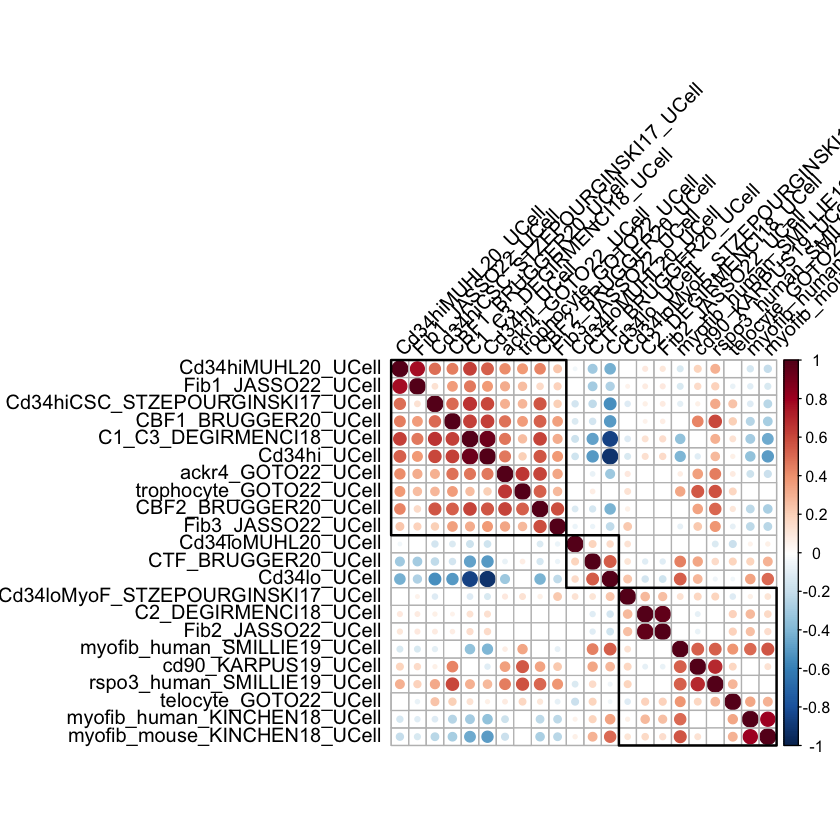

In [20]:
corrplot::corrplot(d_corrhtmp_filt,
    type = "full",
    order = "hclust", hclust.method = "complete",
    tl.col = "black", tl.srt = 45,
    addrect = 3, rect.col = "black", rect.lwd = 2,
    col = rev(corrplot::COL2("RdBu")),
    p.mat = dTest_corrhtmp_filt$p, sig.level = 0.05, insig = "blank"
)

In [21]:
# Plot correlation matrix
pdf(here(
  "output",
  "corrplot.pdf"
), width = 12, height = 12)
corrplot::corrplot(d_corrhtmp_filt,
    type = "full",
    order = "hclust", hclust.method = "complete",
    tl.col = "black", tl.srt = 45,
    addrect = 3, rect.col = "black", rect.lwd = 2,
    col = rev(corrplot::COL2("RdBu")),
    p.mat = dTest_corrhtmp_filt$p, sig.level = 0.05, insig = "blank"
)
dev.off()

pdf 
  2